In [8]:
import pandas as pd
import numpy as np

passes_df = pd.read_pickle('Telesat_0_7day.pkl')

N_passes = 10
passes_df = passes_df[0:N_passes]
    
def non_overlapping_constraint(passes_df):
    # Construct the non-overlapping pass matrix
    b = passes_df.StartTof.values
    e = passes_df.StopTof.values

    B = np.tile(b, (len(passes_df), 1)).T
    E = np.tile(e, (len(passes_df), 1))

    C = np.tril(E - B, -1)

    return C

C = non_overlapping_constraint(passes_df)

In [9]:
import numpy as np

from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.model.problem import Problem


class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=N_passes, n_obj=1, n_constr=N_passes*N_passes, xl=0, xu=1, type_var=np.int)

    def _evaluate(self, xx, out, *args, **kwargs):

        f1 = np.zeros((np.size(xx, 0), 1))
        g1 = np.zeros((np.size(xx, 0), N_passes*N_passes))

        # not vectorized
        for i in range(np.size(xx, 0)):
            x = xx[i,:]

            b = passes_df.StartTof[x == 1].values
            e = passes_df.StopTof[x == 1].values

            contact_time = np.sum(e - b)

            overlap = C * x

            f1[i] = -1 * contact_time
            g1[i,:] = overlap.flatten()

        out["F"] = f1
        out["G"] = g1

method = get_algorithm("ga",
                       pop_size=20,
                       sampling=get_sampling("int_random"),
                       crossover=get_crossover("int_sbx", prob=1.0, eta=3.0),
                       mutation=get_mutation("int_pm", eta=3.0),
                       eliminate_duplicates=True,
                       )

res = minimize(MyProblem(),
               method,
               termination=('n_gen', 40),
               seed=1,
               save_history=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

Best solution found: [1 1 0 1 1 1 0 1 1 1]
Function value: [-1156.]
Constraint violation: [0.]


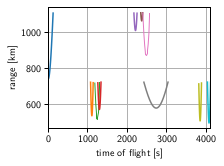

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3.2, 2.4))

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'sans-serif',
    'text.usetex': False,
    'pgf.rcfonts': False
})

lines = [None] * N_passes
for n in range(N_passes):
    pass_df = passes_df.iloc[n]
    line, = plt.plot(pass_df.ttof, pass_df.rrange / 1000., linewidth=0.5)
    lines[n] = line

plt.xlabel('time of flight [s]')
plt.ylabel('range [km]')
plt.grid()
plt.xlim((0, passes_df.iloc[-1].StopTof))
plt.tight_layout()

plt.savefig('D:/git/thesis_report_ae/figures/passes_unmarked.pgf')

for i in np.where(res.X == 1)[0]:
    lines[i].set_linewidth(1.5)

plt.savefig('D:/git/thesis_report_ae/figures/passes_marked.pgf')